<a href="https://colab.research.google.com/github/ad9306/CSP/blob/main/real_section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#직원 퇴사율 예측

In [90]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install roc_curve

In [54]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [55]:
import pandas as pd
df = pd.read_csv('/content/gdrive/MyDrive/CodeStates/kaggle/Employee.csv')
df

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


In [56]:
#프로파일링
import pandas_profiling
pr=df.profile_report()
pr

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

##EDA

In [57]:
#columns name 중 긴 것을 간결하게 조정해줍니다.
df.columns = ['Education', 'Join', 'City', 'PaymentTier', 'Age', 'Gender',
       'Benched', 'Experience', 'Leave']

In [58]:
df.head()

,Education,Join,City,PaymentTier,Age,Gender,Benched,Experience,Leave
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [59]:
#결측치 확인
df.isnull().sum()

Education      0
Join           0
City           0
PaymentTier    0
Age            0
Gender         0
Benched        0
Experience     0
Leave          0
dtype: int64

In [60]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Join,4653.0,2015.062970,1.863377,2012.0,2013.0,2015.0,2017.0,2018.0
PaymentTier,4653.0,2.698259,0.561435,1.0,3.0,3.0,3.0,3.0
Age,4653.0,29.393295,4.826087,22.0,26.0,28.0,32.0,41.0
Experience,4653.0,2.905652,1.558240,0.0,2.0,3.0,4.0,7.0
Leave,4653.0,0.343864,0.475047,0.0,0.0,0.0,1.0,1.0


In [61]:
#분포확인
df['Leave'].value_counts(normalize=True)

0    0.656136
1    0.343864
Name: Leave, dtype: float64

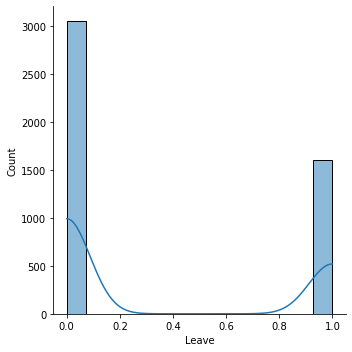

In [62]:
import seaborn as sns
sns.displot(df['Leave'], kde=True);

In [63]:
#basline = 0.66
ratio = 0.343864 / 0.656136
ratio

0.5240742772839777

##모델링

In [64]:
#data split을 통하여 훈련/검증/테스트 로 분리한다.
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(df, test_size=0.2, random_state=2)
train, val = train_test_split(train_val, test_size=len(test), random_state=2)

print(f'train:{train.shape}, val:{val.shape}, test:{test.shape}')

train:(2791, 9), val:(931, 9), test:(931, 9)


In [65]:
target = 'Leave'

X_train = train.drop(target, axis=1)
y_train = train[target]
X_val = val.drop(target, axis=1)
y_val = val[target]
X_test = test.drop(target, axis=1)
y_test = test[target]

###모델1 Decision Trees

In [66]:
#OHE
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

pipe1 = make_pipeline(
    OneHotEncoder(use_cat_names=True),  
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=2, criterion='entropy')
)

pipe1.fit(X_train, y_train)
print('훈련 정확도: ', pipe1.score(X_train, y_train))
print('검증 정확도: ', pipe1.score(X_val, y_val))

훈련 정확도:  0.9301325689716947
검증 정확도:  0.8120300751879699


In [67]:
y_val.value_counts(normalize=True)

0    0.648765
1    0.351235
Name: Leave, dtype: float64

In [68]:
#Ordinal
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

pipe1 = make_pipeline(
    OrdinalEncoder(),  
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=2, criterion='entropy')
)

pipe1.fit(X_train, y_train)
print('훈련 정확도: ', pipe1.score(X_train, y_train))
print('검증 정확도: ', pipe1.score(X_val, y_val))

훈련 정확도:  0.9301325689716947
검증 정확도:  0.8141783029001074


max_depth를 설정하여 정확도를 조정한다

In [69]:
#OHE
pipe1 = make_pipeline(
    OneHotEncoder(use_cat_names=True),  
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=8, random_state=2, criterion='entropy')
)

pipe1.fit(X_train, y_train)
print('훈련 정확도: ', pipe1.score(X_train, y_train))
print('검증 정확도: ', pipe1.score(X_val, y_val))

훈련 정확도:  0.8656395557147976
검증 정확도:  0.8528464017185822


In [70]:
#Ordinal
pipe1 = make_pipeline(
    OrdinalEncoder(),  
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=8, random_state=2, criterion='entropy')
)

pipe1.fit(X_train, y_train)
print('훈련 정확도: ', pipe1.score(X_train, y_train))
print('검증 정확도: ', pipe1.score(X_val, y_val))

훈련 정확도:  0.8599068434252956
검증 정확도:  0.8539205155746509


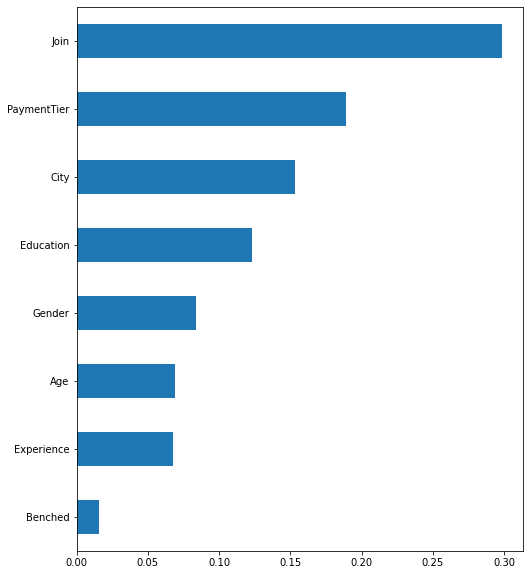

In [71]:
import matplotlib.pyplot as plt

model_dt = pipe1.named_steps['decisiontreeclassifier']

enc = pipe1.named_steps['ordinalencoder']
importances = pd.Series(model_dt.feature_importances_, enc.transform(X_val).columns)
plt.figure(figsize=(8,10))
importances.sort_values().plot.barh();

In [72]:
from sklearn.metrics import classification_report
y_pred = pipe1.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.89       604
           1       0.87      0.69      0.77       327

    accuracy                           0.85       931
   macro avg       0.86      0.82      0.83       931
weighted avg       0.86      0.85      0.85       931



###모델2 Randomforest

In [73]:
from sklearn.ensemble import RandomForestClassifier

pipe2 = make_pipeline(
    OneHotEncoder(use_cat_names=True),  
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe2.fit(X_train, y_train)
print('훈련 정확도: ', pipe2.score(X_train, y_train))
print('검증 정확도: ', pipe2.score(X_val, y_val))

훈련 정확도:  0.9301325689716947
검증 정확도:  0.8206229860365198


In [74]:
pipe2 = make_pipeline(
    OrdinalEncoder(),  
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe2.fit(X_train, y_train)
print('훈련 정확도: ', pipe2.score(X_train, y_train))
print('검증 정확도: ', pipe2.score(X_val, y_val))

훈련 정확도:  0.9301325689716947
검증 정확도:  0.8270676691729323


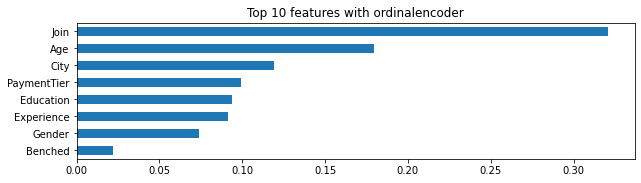

In [75]:
# 특성 중요도(ordinal)
rf_ord = pipe2.named_steps['randomforestclassifier']
enc = pipe2.named_steps['ordinalencoder']
importances_ord = pd.Series(rf_ord.feature_importances_, enc.transform(X_train).columns)

n=10
plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with ordinalencoder')
importances_ord.sort_values()[-n:].plot.barh();

In [76]:
y_pred = pipe2.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       604
           1       0.77      0.72      0.74       327

    accuracy                           0.83       931
   macro avg       0.81      0.80      0.81       931
weighted avg       0.82      0.83      0.83       931



###하이퍼파라미터 튜닝

In [83]:
from sklearn.model_selection import GridSearchCV

params ={
    'n_estimators': [100, 200, 300],
    'max_depth':[5,10,15]
}
encoder = OrdinalEncoder()

In [85]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf, param_grid=params, cv=3, n_jobs=-1)
grid_cv.fit(encoder.fit_transform(X_train), y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=0,
                                     

In [86]:
print('최적 하이퍼파라미터: ', grid_cv.best_params_)

최적 하이퍼파라미터:  {'max_depth': 10, 'n_estimators': 100}


In [88]:
pipe3 = make_pipeline(
    OrdinalEncoder(),  
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, max_depth=10, n_estimators=100, oob_score=True)
)

pipe3.fit(X_train, y_train)
print('훈련 정확도: ', pipe2.score(X_train, y_train))
print('검증 정확도: ', pipe2.score(X_val, y_val))

훈련 정확도:  0.9301325689716947
검증 정확도:  0.8270676691729323


In [94]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
#최적의 threshold 구하기
y_pred_proba = pipe3.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,2.000000
1,0.000000,0.003058,1.000000
2,0.000000,0.012232,0.997138
3,0.000000,0.024465,0.994260
4,0.000000,0.027523,0.994055
...,...,...,...
340,0.981788,1.000000,0.030184
341,0.985099,1.000000,0.029991
342,0.990066,1.000000,0.029818
343,0.998344,1.000000,0.026175


In [96]:
import numpy as np
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 92 , threshold: 0.5256218804102973


In [97]:
#threshold 설정
y_pred_optimal = y_pred_proba >= optimal_threshold
print(classification_report(y_val, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       604
           1       0.90      0.71      0.80       327

    accuracy                           0.87       931
   macro avg       0.88      0.83      0.85       931
weighted avg       0.87      0.87      0.87       931



In [102]:
from sklearn.metrics import accuracy_score

auc_score = roc_auc_score(y_val, y_pred_optimal)
print('최종 auc점수 : ', auc_score)
print('최종 종합지표 : ', classification_report(y_val, y_pred_optimal))

최종 auc점수 :  0.8347459343419001
최종 종합지표 :                precision    recall  f1-score   support

           0       0.86      0.96      0.91       604
           1       0.90      0.71      0.80       327

    accuracy                           0.87       931
   macro avg       0.88      0.83      0.85       931
weighted avg       0.87      0.87      0.87       931



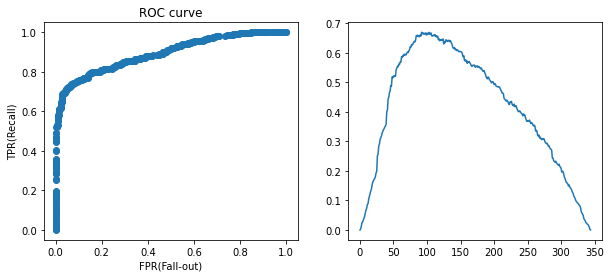

In [103]:
#roc와 auc 시각화
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

plt.subplot(122)
plt.plot(tpr-fpr);

###최종모델

In [104]:
pipe_O = make_pipeline(
    OrdinalEncoder(),  
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, max_depth=10, n_estimators=100, oob_score=True)
)

pipe_O.fit(X_train, y_train)

y_pred = pipe_O.predict(X_val)
y_pred_proba = pipe_O.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred_optimal = y_pred_proba >= optimal_threshold

auc_score = roc_auc_score(y_val, y_pred_optimal)
print('최종 auc점수 : ', auc_score)
print(classification_report(y_val, y_pred_optimal))

최종 auc점수 :  0.8347459343419001
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       604
           1       0.90      0.71      0.80       327

    accuracy                           0.87       931
   macro avg       0.88      0.83      0.85       931
weighted avg       0.87      0.87      0.87       931



In [147]:
encoder = OrdinalEncoder()
X_train_enc = encoder.fit_transform(X_train)
X_val_enc = encoder.transform(X_val)
X_test_enc = encoder.transform(X_test)

model = RandomForestClassifier(n_jobs=-1, random_state=10, max_depth=10, n_estimators=100, oob_score=True)

model.fit(X_train_enc, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)

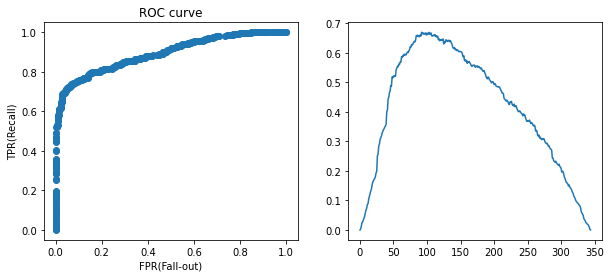

In [105]:
#최종모델 roc auc시각화
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

plt.subplot(122)
plt.plot(tpr-fpr);

####Test 데이터 성능 확인

In [107]:
y_pred = pipe_O.predict(X_test)
y_pred_proba = pipe_O.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('idx:', optimal_idx, ', threshold:', optimal_threshold)

y_pred_optimal = y_pred_proba >= optimal_threshold
print(classification_report(y_test, y_pred_optimal))

idx: 84 , threshold: 0.422867620790958
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       638
           1       0.83      0.73      0.78       293

    accuracy                           0.87       931
   macro avg       0.86      0.83      0.84       931
weighted avg       0.87      0.87      0.87       931



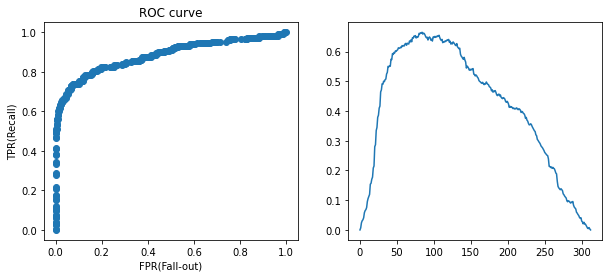

In [108]:
#roc auc 시각화
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

plt.subplot(122)
plt.plot(tpr-fpr);

####순열중요도

In [112]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    pipe_O.named_steps['randomforestclassifier'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업
permuter.fit(enc.transform(X_val), y_val);
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Benched        0.002363
Experience     0.014178
Age            0.017615
PaymentTier    0.062299
City           0.069173
Gender         0.085285
Education      0.087433
Join           0.123093
dtype: float64

In [113]:
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.1231 ± 0.0090,Join
0.0874 ± 0.0059,Education
0.0853 ± 0.0147,Gender
0.0692 ± 0.0080,City
0.0623 ± 0.0148,PaymentTier
0.0176 ± 0.0070,Age
0.0142 ± 0.0064,Experience
0.0024 ± 0.0032,Benched


###PDP

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


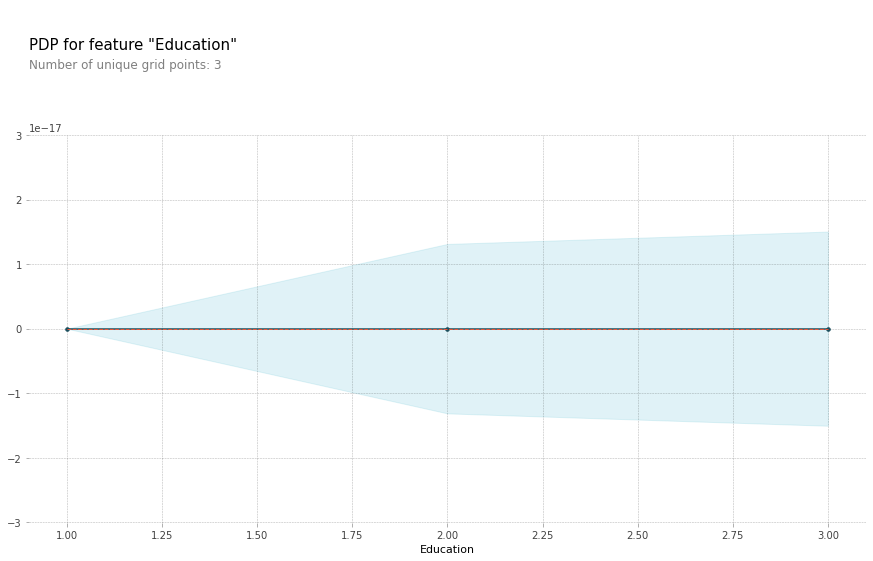

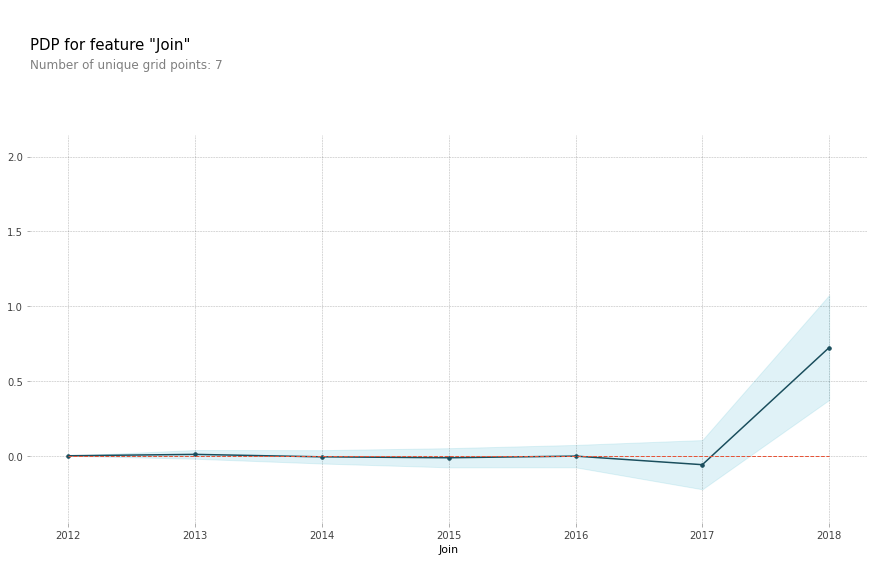

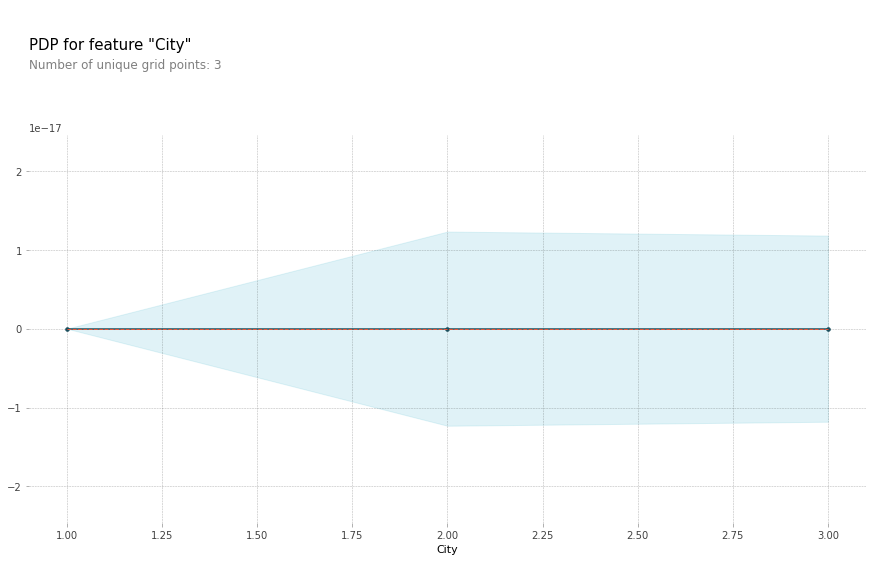

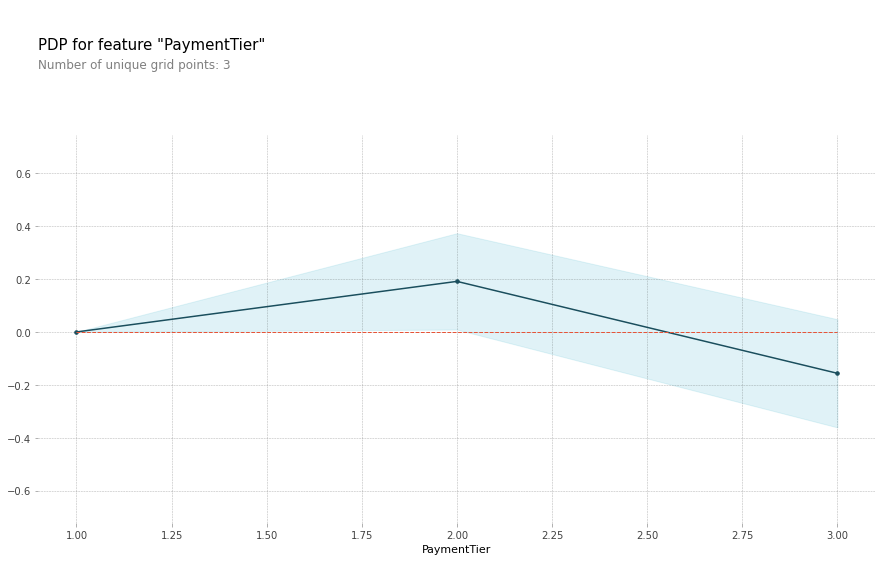

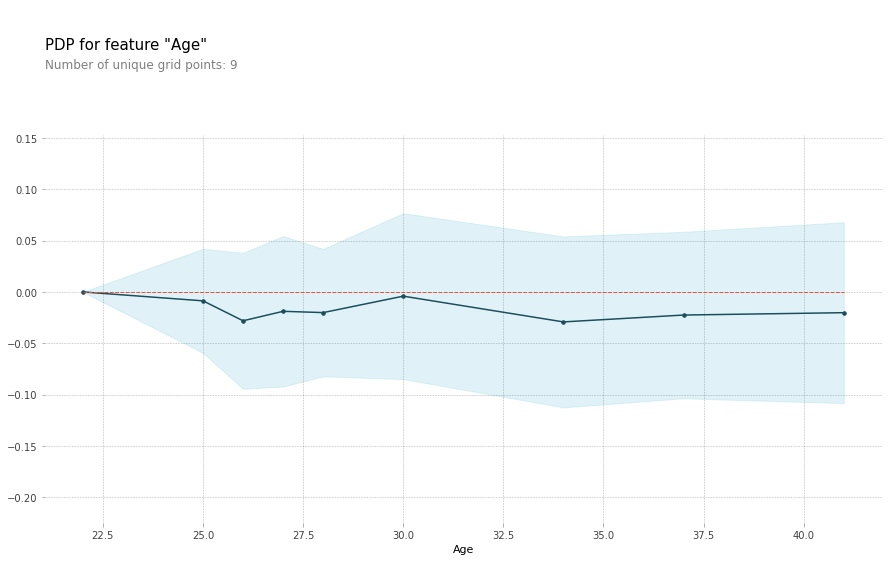

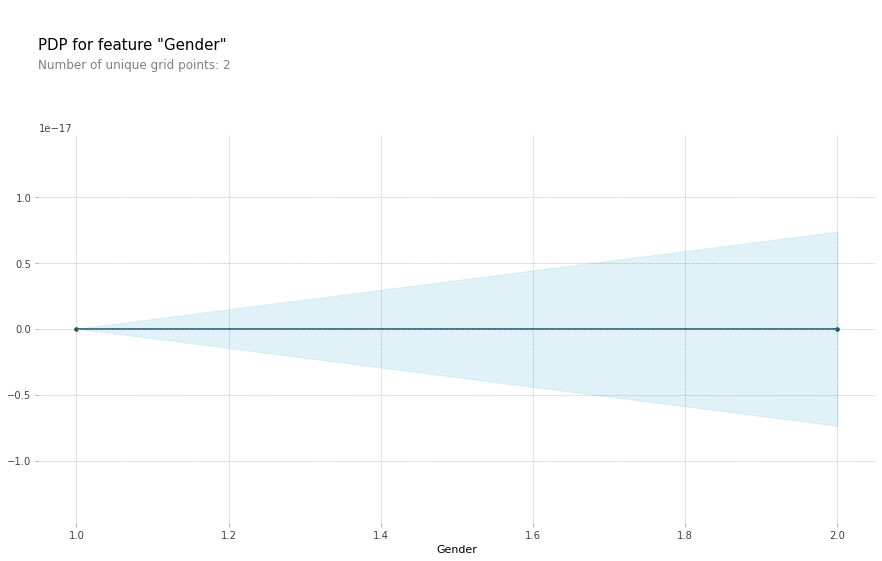

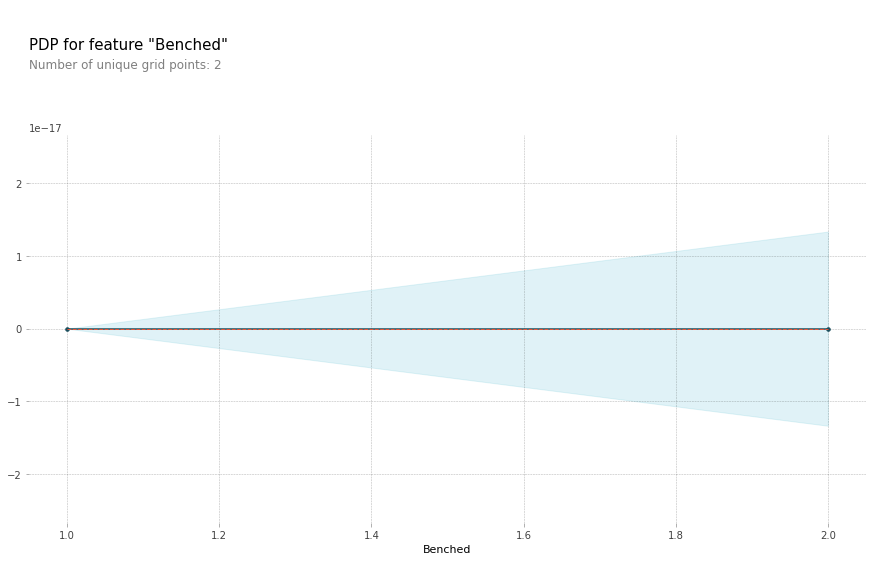

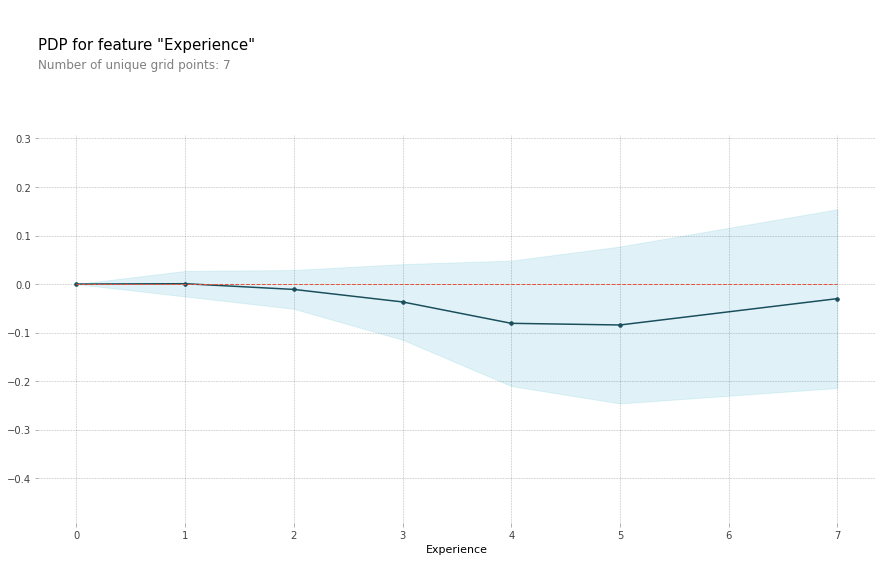

In [116]:
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot

features = ['Education', 'Join', 'City', 'PaymentTier', 'Age', 'Gender',
       'Benched', 'Experience']

for a in features:
  feature = a
  isolated = pdp_isolate(
      model=pipe_O,
      dataset=enc.fit_transform(X_train),
      model_features=enc.fit_transform(X_train).columns,
      feature=feature
  )
  pdp_plot(isolated, feature_name=feature);

payment tier, age, experience 가 음으로 나타나고 join은 양의 상관계수, 나머지는 0에 가까운 형태를 나타낸다

###SHAP

In [163]:
import shap
explainer = shap.TreeExplainer(model)
row = X_train_enc.iloc[[1]]
shap_values = explainer.shap_values(X_train_enc.iloc[:100])

In [150]:
row

,Education,Join,City,PaymentTier,Age,Gender,Benched,Experience
3529,1,2017,1,3,31,2,1,0


In [149]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_train_enc.iloc[:100])

AssertionError: ignored